In [1]:
from utils.binaries import *
from utils.plotting import *

18:34:26 (   +1.4s) [INFO   ] -- import logging
18:34:26 (  +193ms) [INFO   ] -- import numpy as np
18:34:26 (   +11ms) [INFO   ] -- import uncertainties
18:34:27 (  +582ms) [INFO   ] -- import pandas as pd
18:34:27 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
18:34:27 (    +3ms) [INFO   ] -- import binaries.tools as tools
18:34:27 (  +515ms) [INFO   ] -- import matplotlib.pyplot as plt
18:34:28 (  +728ms) [INFO   ] -- import seaborn as so
18:34:28 (    +2ms) [INFO   ] -- import plotting.tools as plot
18:34:28 (   +16ms) [DEBUG  ] -- font size set to 9.5
18:34:28 (    +1ms) [DEBUG  ] -- label size set to 13.0
18:34:28 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
18:34:28 (    +1ms) [DEBUG  ] -- markersize set to 2.0
18:34:28 (    +0ms) [DEBUG  ] -- usetex set to False


In [2]:
from datetime import date, timedelta
from datetime import datetime

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

def get_data(station, start_dt, end_dt):

    x1, y1, yerr1 = [], [], []
    x2, y2, yerr2 = [], [], []
    x3, y3, yerr3 = [], [], []

    path = '/cr/work/filip/weather_correlation'
    for d in daterange(start_dt, end_dt):
    
        temperature_measurements, pressure_measurements = 0, 0

        weather_AERAWS = np.loadtxt(f"{path}/AERAWS_{d.year:04}_{d.month:02}_{d.day:02}.dat")
        weather_CRS = np.loadtxt(f"{path}/CRS_{d.year:04}_{d.month:02}_{d.day:02}.dat")
        peaks = np.loadtxt(f"{path}/peaks_{d.year:04}_{d.month:02}_{d.day:02}.dat")

        for peak in peaks:
            if peak[0] != station: continue
            idx_AERAWS = tools.closest(weather_AERAWS[:, 0], peak[1], index=True)
            idx_CRS = tools.closest(weather_CRS[:, 0], peak[1], index=True)
            
            if np.isnan(peak[3]): continue
            if np.abs(peak[3]) > 0.4: continue

            if True:
                dd = datetime.fromtimestamp(peak[1])
                x3.append(dd.hour + dd.minute/60 + dd.second/3600)
                y3.append(peak[3])
                yerr3.append(peak[4])

            if np.abs(weather_AERAWS[idx_AERAWS, 0] - peak[1]) < 300:

                pressure_value_is_bogus = weather_AERAWS[idx_AERAWS, 1] < 600
                pressure_is_nan = np.isnan(weather_AERAWS[idx_AERAWS, 1])

                if not (pressure_value_is_bogus or pressure_is_nan):
                    x1.append(weather_AERAWS[idx_AERAWS, 1])
                    y1.append(peak[3])
                    yerr1.append(peak[4])
                    pressure_measurements += 1

            if np.abs(weather_CRS[idx_CRS, 0] - peak[1]) < 300:

                temperature_is_bogus = np.isnan(weather_CRS[idx_CRS, 1])

                if not (temperature_is_bogus or False):
                    x2.append(weather_CRS[idx_CRS, 2])
                    y2.append(peak[3])
                    yerr2.append(peak[4])
                    temperature_measurements += 1

        print(f"{d}: {temperature_measurements = }, {pressure_measurements = }")

    return x1, x2, x3, y1, y2, y3, yerr1, yerr2, yerr3

def make_plot(station, start_dt, end_dt):

    def ptp(x, y):

        indices = np.argsort(x)

        mean_start = np.mean(np.array(y)[indices][:10])
        mean_end = np.mean(np.array(y)[indices][-10:])

        return mean_start, mean_end, np.abs((mean_start - mean_end) / np.mean(x))

    x1, x2, x3, y1, y2, y3, yerr1, yerr2, yerr3 = get_data(station, start_dt, end_dt)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    fig.suptitle(f"Station ID = {station}")

    i1, f1, ptp1 = ptp(x1, y1)
    ax1.axhline(i1, xmax=0.1, c='r', label='low mean')
    ax1.axhline(f1, xmin=0.9, c='b', label='high mean')
    ax1.set_xlabel("pressure / hPa")
    ax1.set_ylabel("$I^\mathrm{SSD}_\mathrm{rate} - I^\mathrm{SSD}_\mathrm{histo}$ / $I^\mathrm{SSD}_\mathrm{histo}$")
    ax1.errorbar(x1, y1, yerr1, fmt='ko', lw=0.1)
    ax1.text(
        0.04, 0.96, rf"$\rho$ = {np.corrcoef(x1, y1)[0, 1]:.2f}, $2\hat{{A}}$ = {ptp1 * 100:.4f}%",
        ha='left', va='center',
        transform=ax1.transAxes,
    )

    i2, f2, ptp2 = ptp(x2, y2)
    ax2.axhline(i2, xmax=0.1, c='r', label='low mean', zorder=10)
    ax2.axhline(f2, xmin=0.9, c='b', label='high mean', zorder=10)
    ax2.set_xlabel("temperature / $^\circ$C")
    ax2.errorbar(x2, y2, yerr2, fmt='ko', lw=0.1)
    ax2.text(
        0.04, 0.96, rf"$\rho$ = {np.corrcoef(x2, y2)[0, 1]:.2f}, $2\hat{{A}}$ = {ptp2 * 100:.4f}%",
        ha='left', va='center',
        transform=ax2.transAxes,
    )

    i3, f3, ptp3 = ptp(x3, y3)
    ax3.axhline(i3, xmax=0.1, c='r', label='low mean', zorder=10)
    ax3.axhline(f3, xmin=0.9, c='b', label='high mean', zorder=10)
    ax3.set_xlabel("time of day / h")
    ax3.errorbar(x3, y3, yerr3, fmt='ko', lw=0.1)
    ax3.text(
        0.04, 0.96, rf"$\rho$ = {np.corrcoef(x2, y2)[0, 1]:.2f}, $2\hat{{A}}$ = {ptp3 * 100:.4f}%",
        ha='left', va='center',
        transform=ax3.transAxes,
    )

    # ax1.legend()
    # ax2.legend()
    plt.subplots_adjust(wspace=0.04)

In [3]:
START = date(2025, 1, 7)
STOP = date(2025, 1, 13)

2025-01-07: temperature_measurements = 17, pressure_measurements = 0
2025-01-08: temperature_measurements = 92, pressure_measurements = 17
2025-01-09: temperature_measurements = 57, pressure_measurements = 8
2025-01-10: temperature_measurements = 0, pressure_measurements = 0
2025-01-11: temperature_measurements = 0, pressure_measurements = 0
2025-01-12: temperature_measurements = 0, pressure_measurements = 0
2025-01-13: temperature_measurements = 0, pressure_measurements = 0


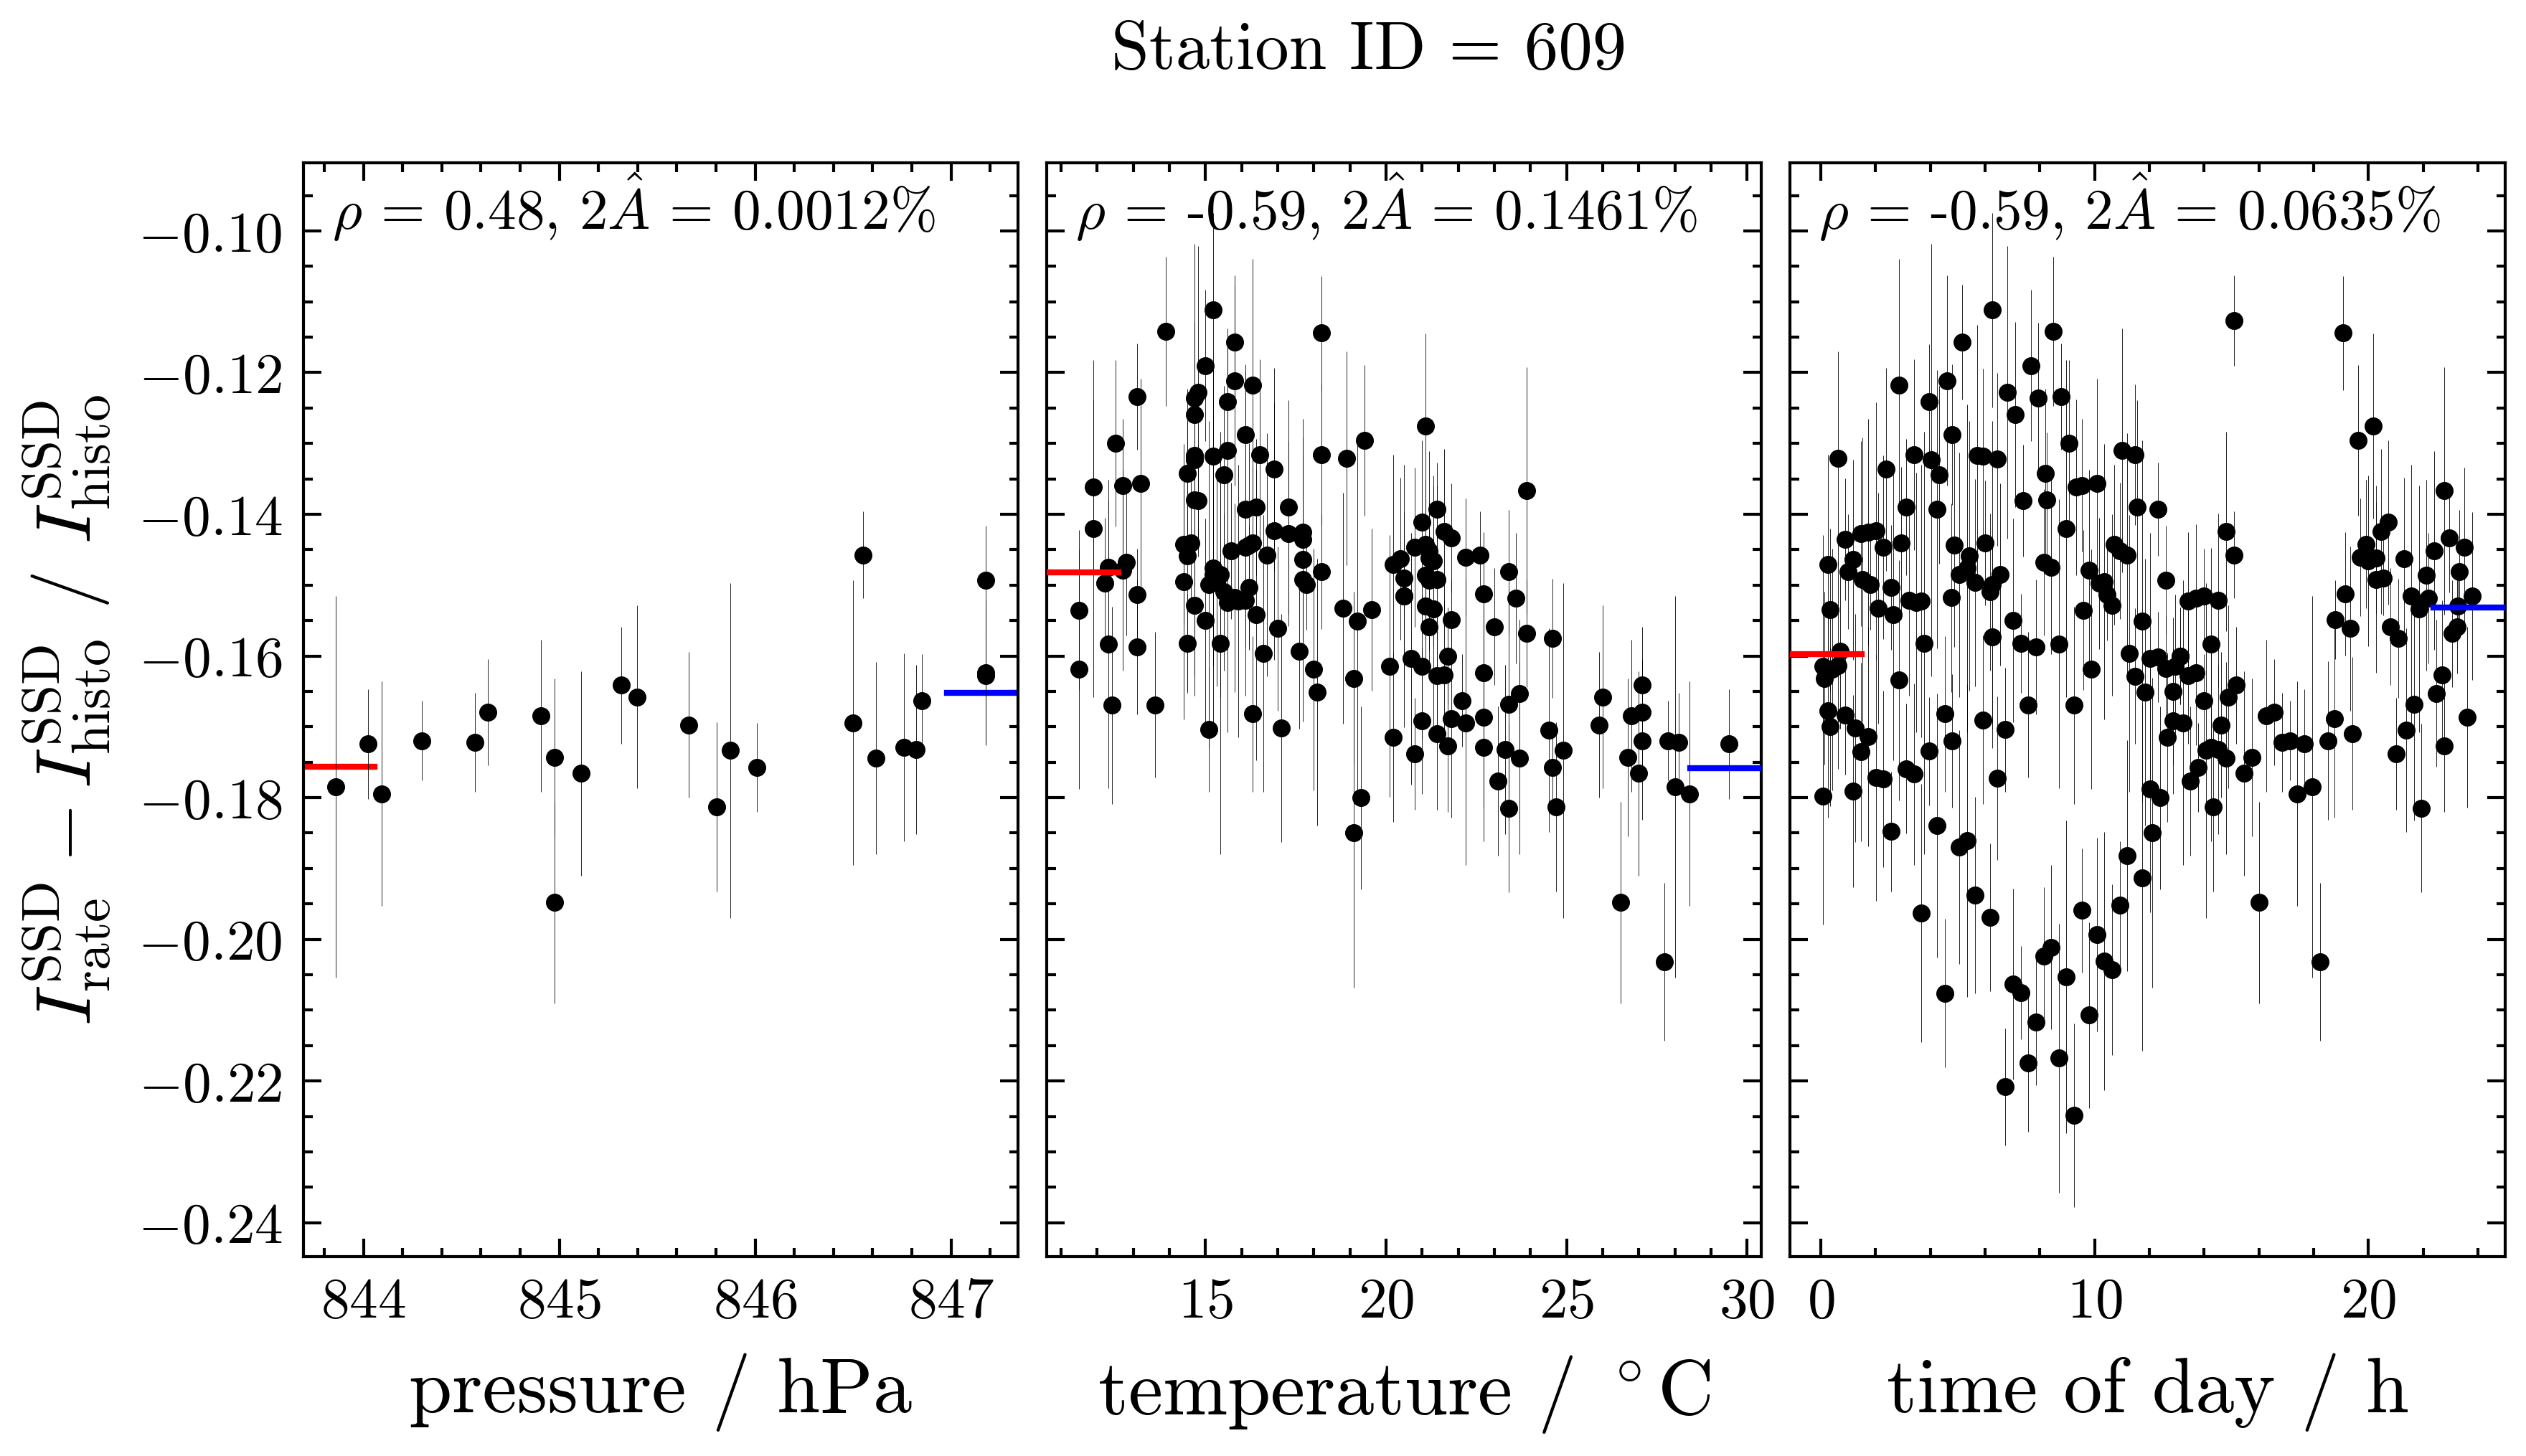

In [4]:
make_plot(609, START, STOP)

2025-01-07: temperature_measurements = 20, pressure_measurements = 0
2025-01-08: temperature_measurements = 84, pressure_measurements = 16
2025-01-09: temperature_measurements = 92, pressure_measurements = 22
2025-01-10: temperature_measurements = 86, pressure_measurements = 20
2025-01-11: temperature_measurements = 98, pressure_measurements = 22
2025-01-12: temperature_measurements = 93, pressure_measurements = 23
2025-01-13: temperature_measurements = 91, pressure_measurements = 25


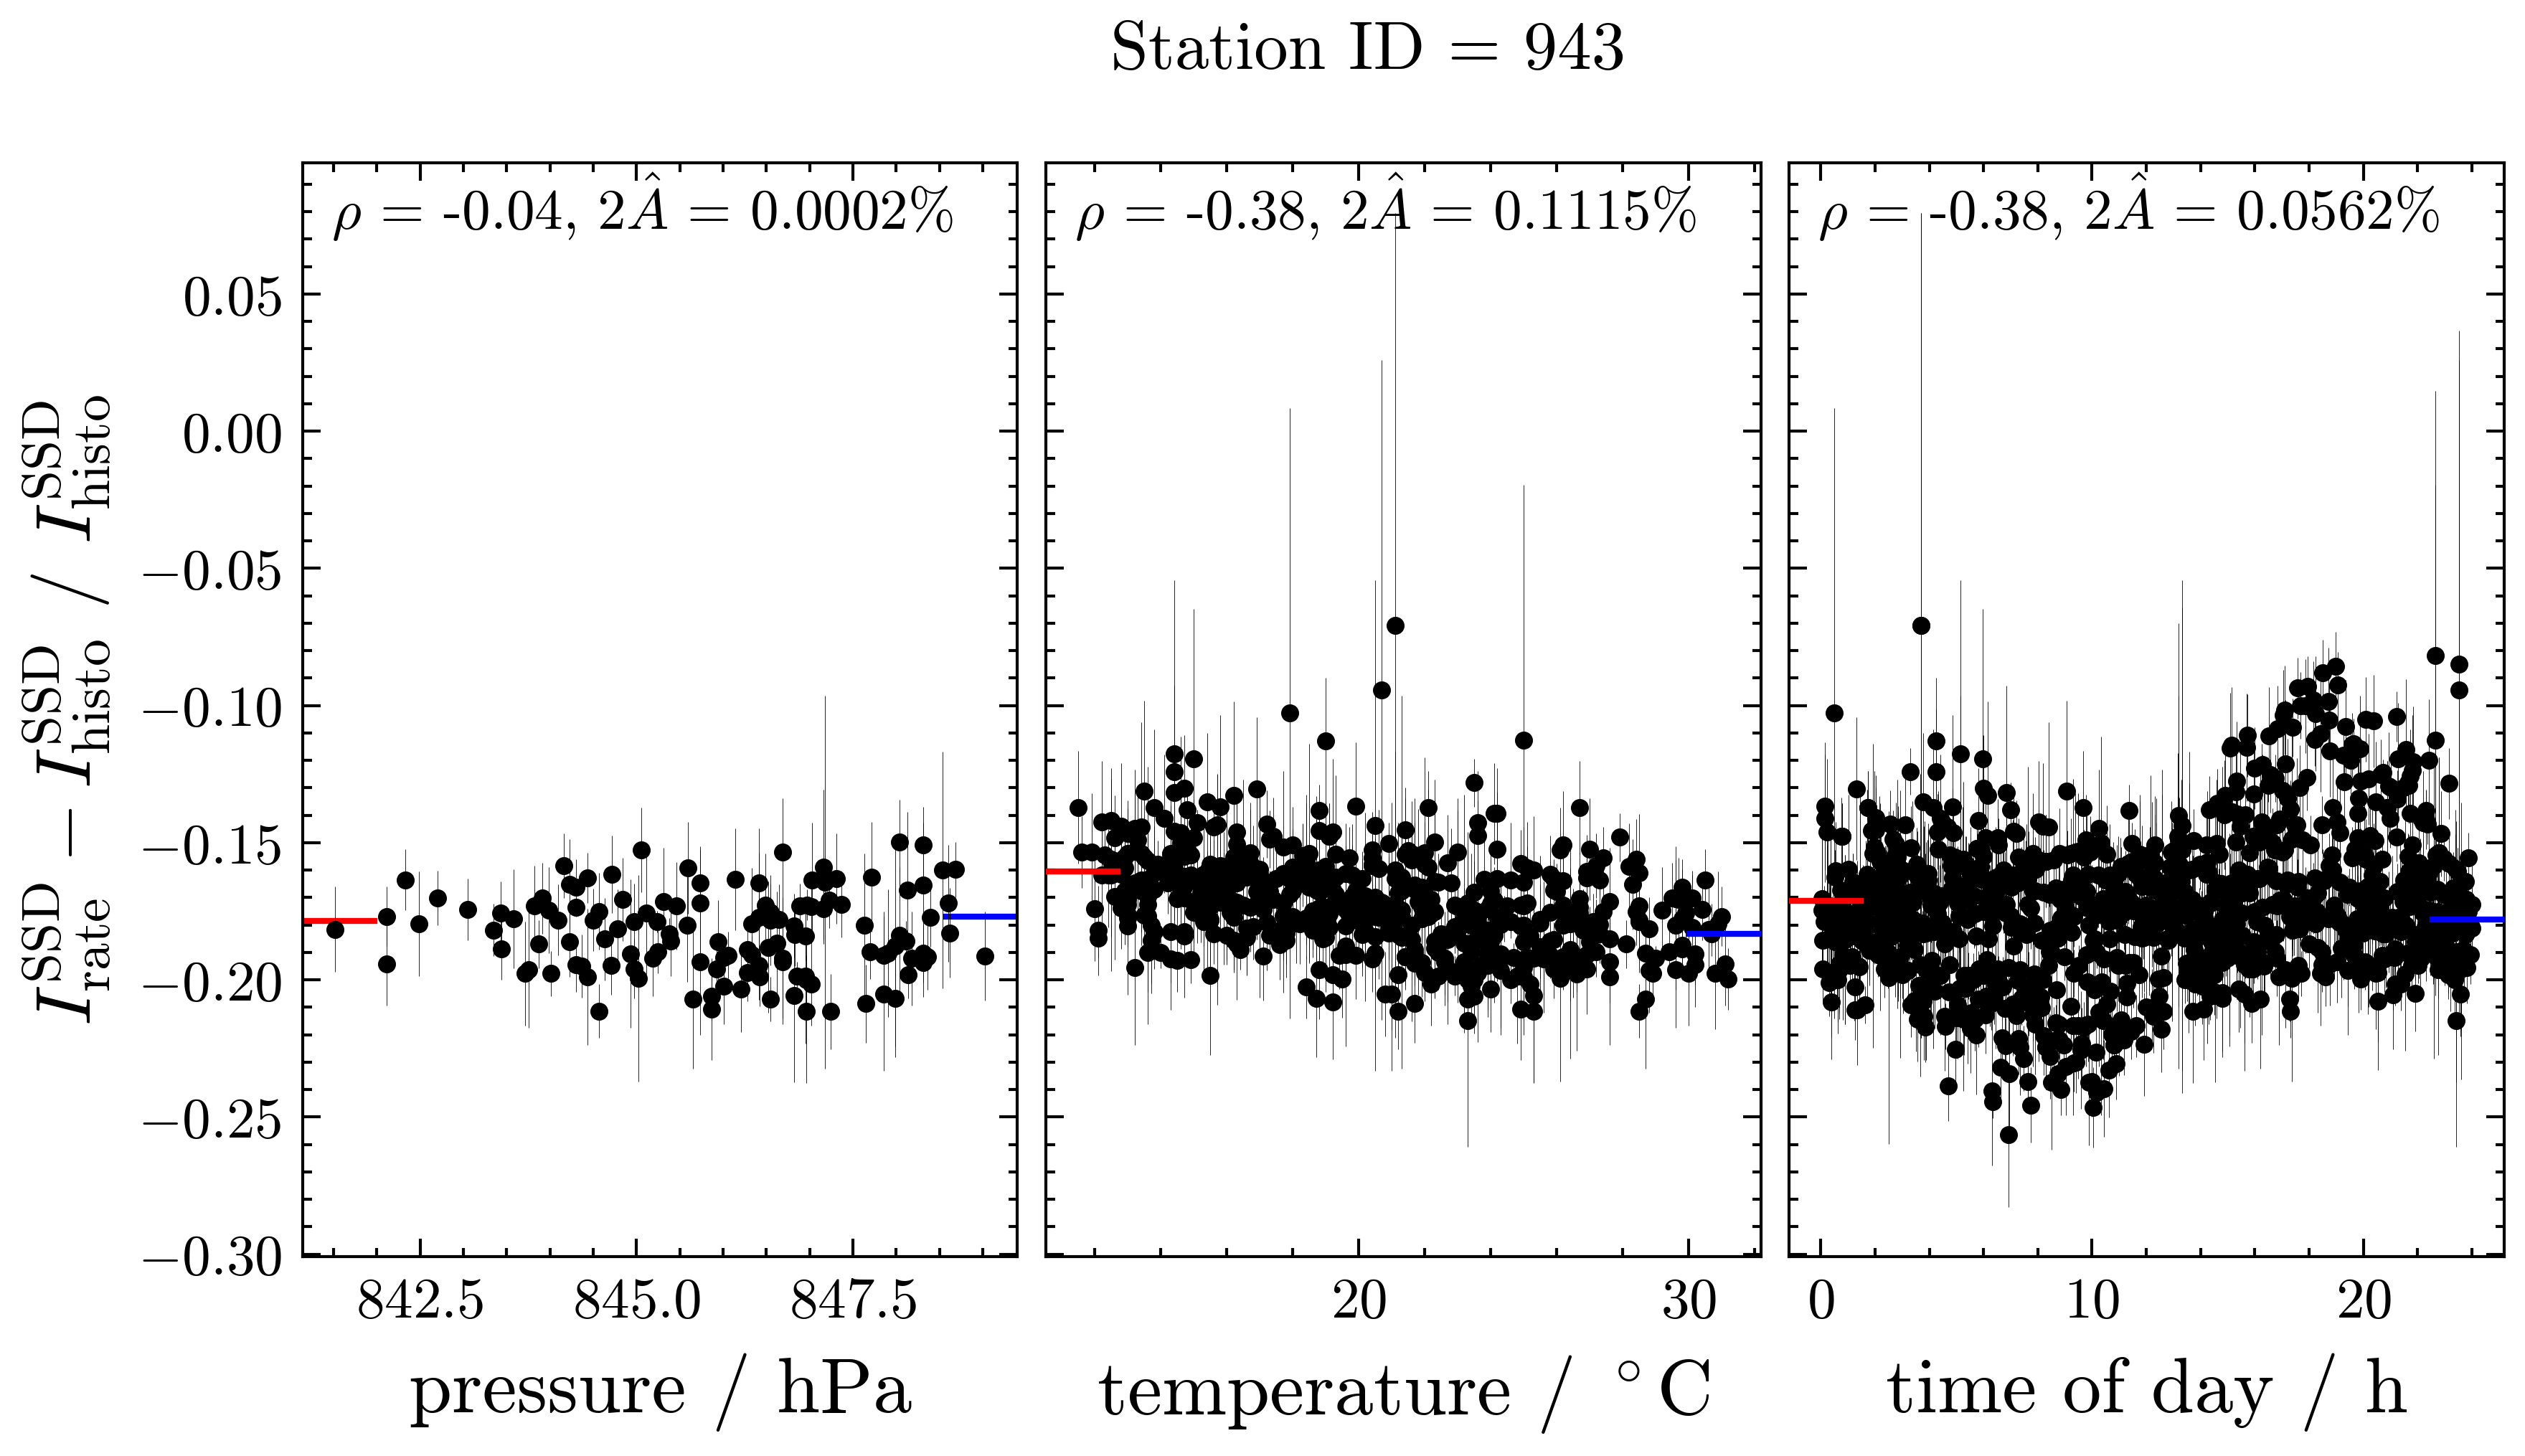

In [5]:
make_plot(943, START, STOP)

2025-01-07: temperature_measurements = 22, pressure_measurements = 0
2025-01-08: temperature_measurements = 98, pressure_measurements = 21
2025-01-09: temperature_measurements = 96, pressure_measurements = 24
2025-01-10: temperature_measurements = 88, pressure_measurements = 19
2025-01-11: temperature_measurements = 92, pressure_measurements = 20
2025-01-12: temperature_measurements = 93, pressure_measurements = 23
2025-01-13: temperature_measurements = 95, pressure_measurements = 25


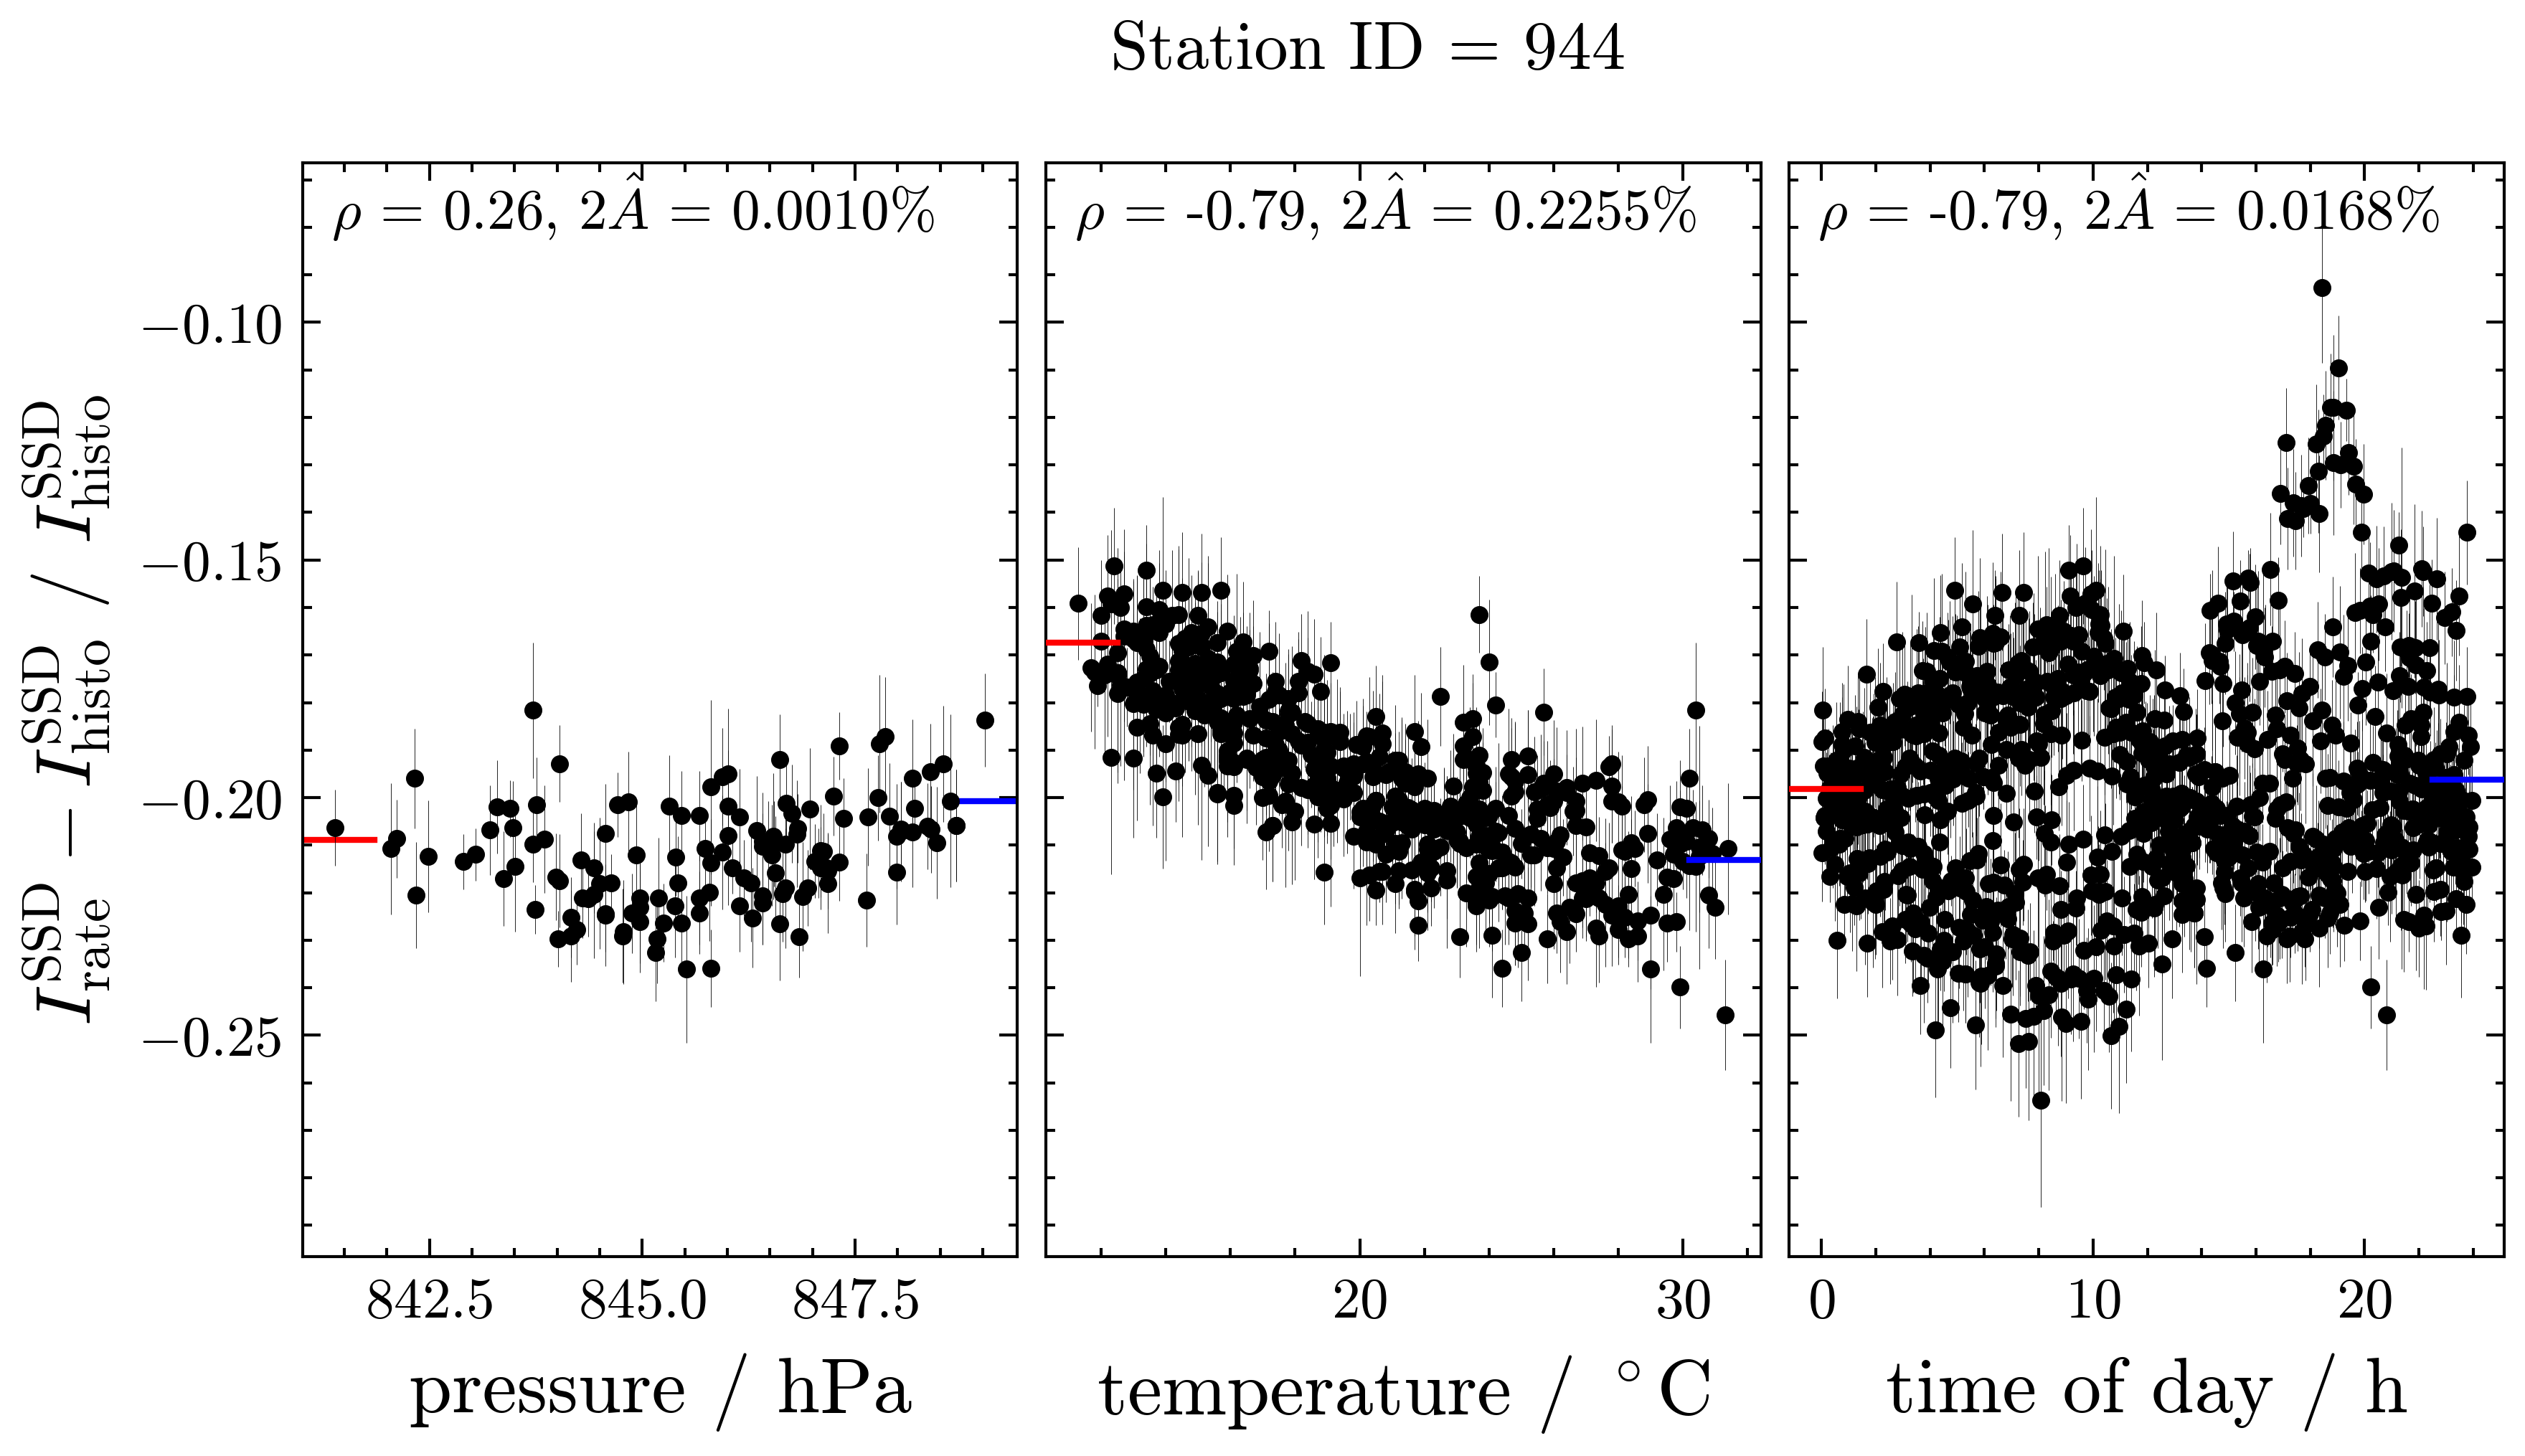

In [6]:
make_plot(944, START, STOP)

2025-01-07: temperature_measurements = 19, pressure_measurements = 0
2025-01-08: temperature_measurements = 96, pressure_measurements = 20
2025-01-09: temperature_measurements = 87, pressure_measurements = 21
2025-01-10: temperature_measurements = 95, pressure_measurements = 27
2025-01-11: temperature_measurements = 91, pressure_measurements = 21
2025-01-12: temperature_measurements = 94, pressure_measurements = 25
2025-01-13: temperature_measurements = 93, pressure_measurements = 28


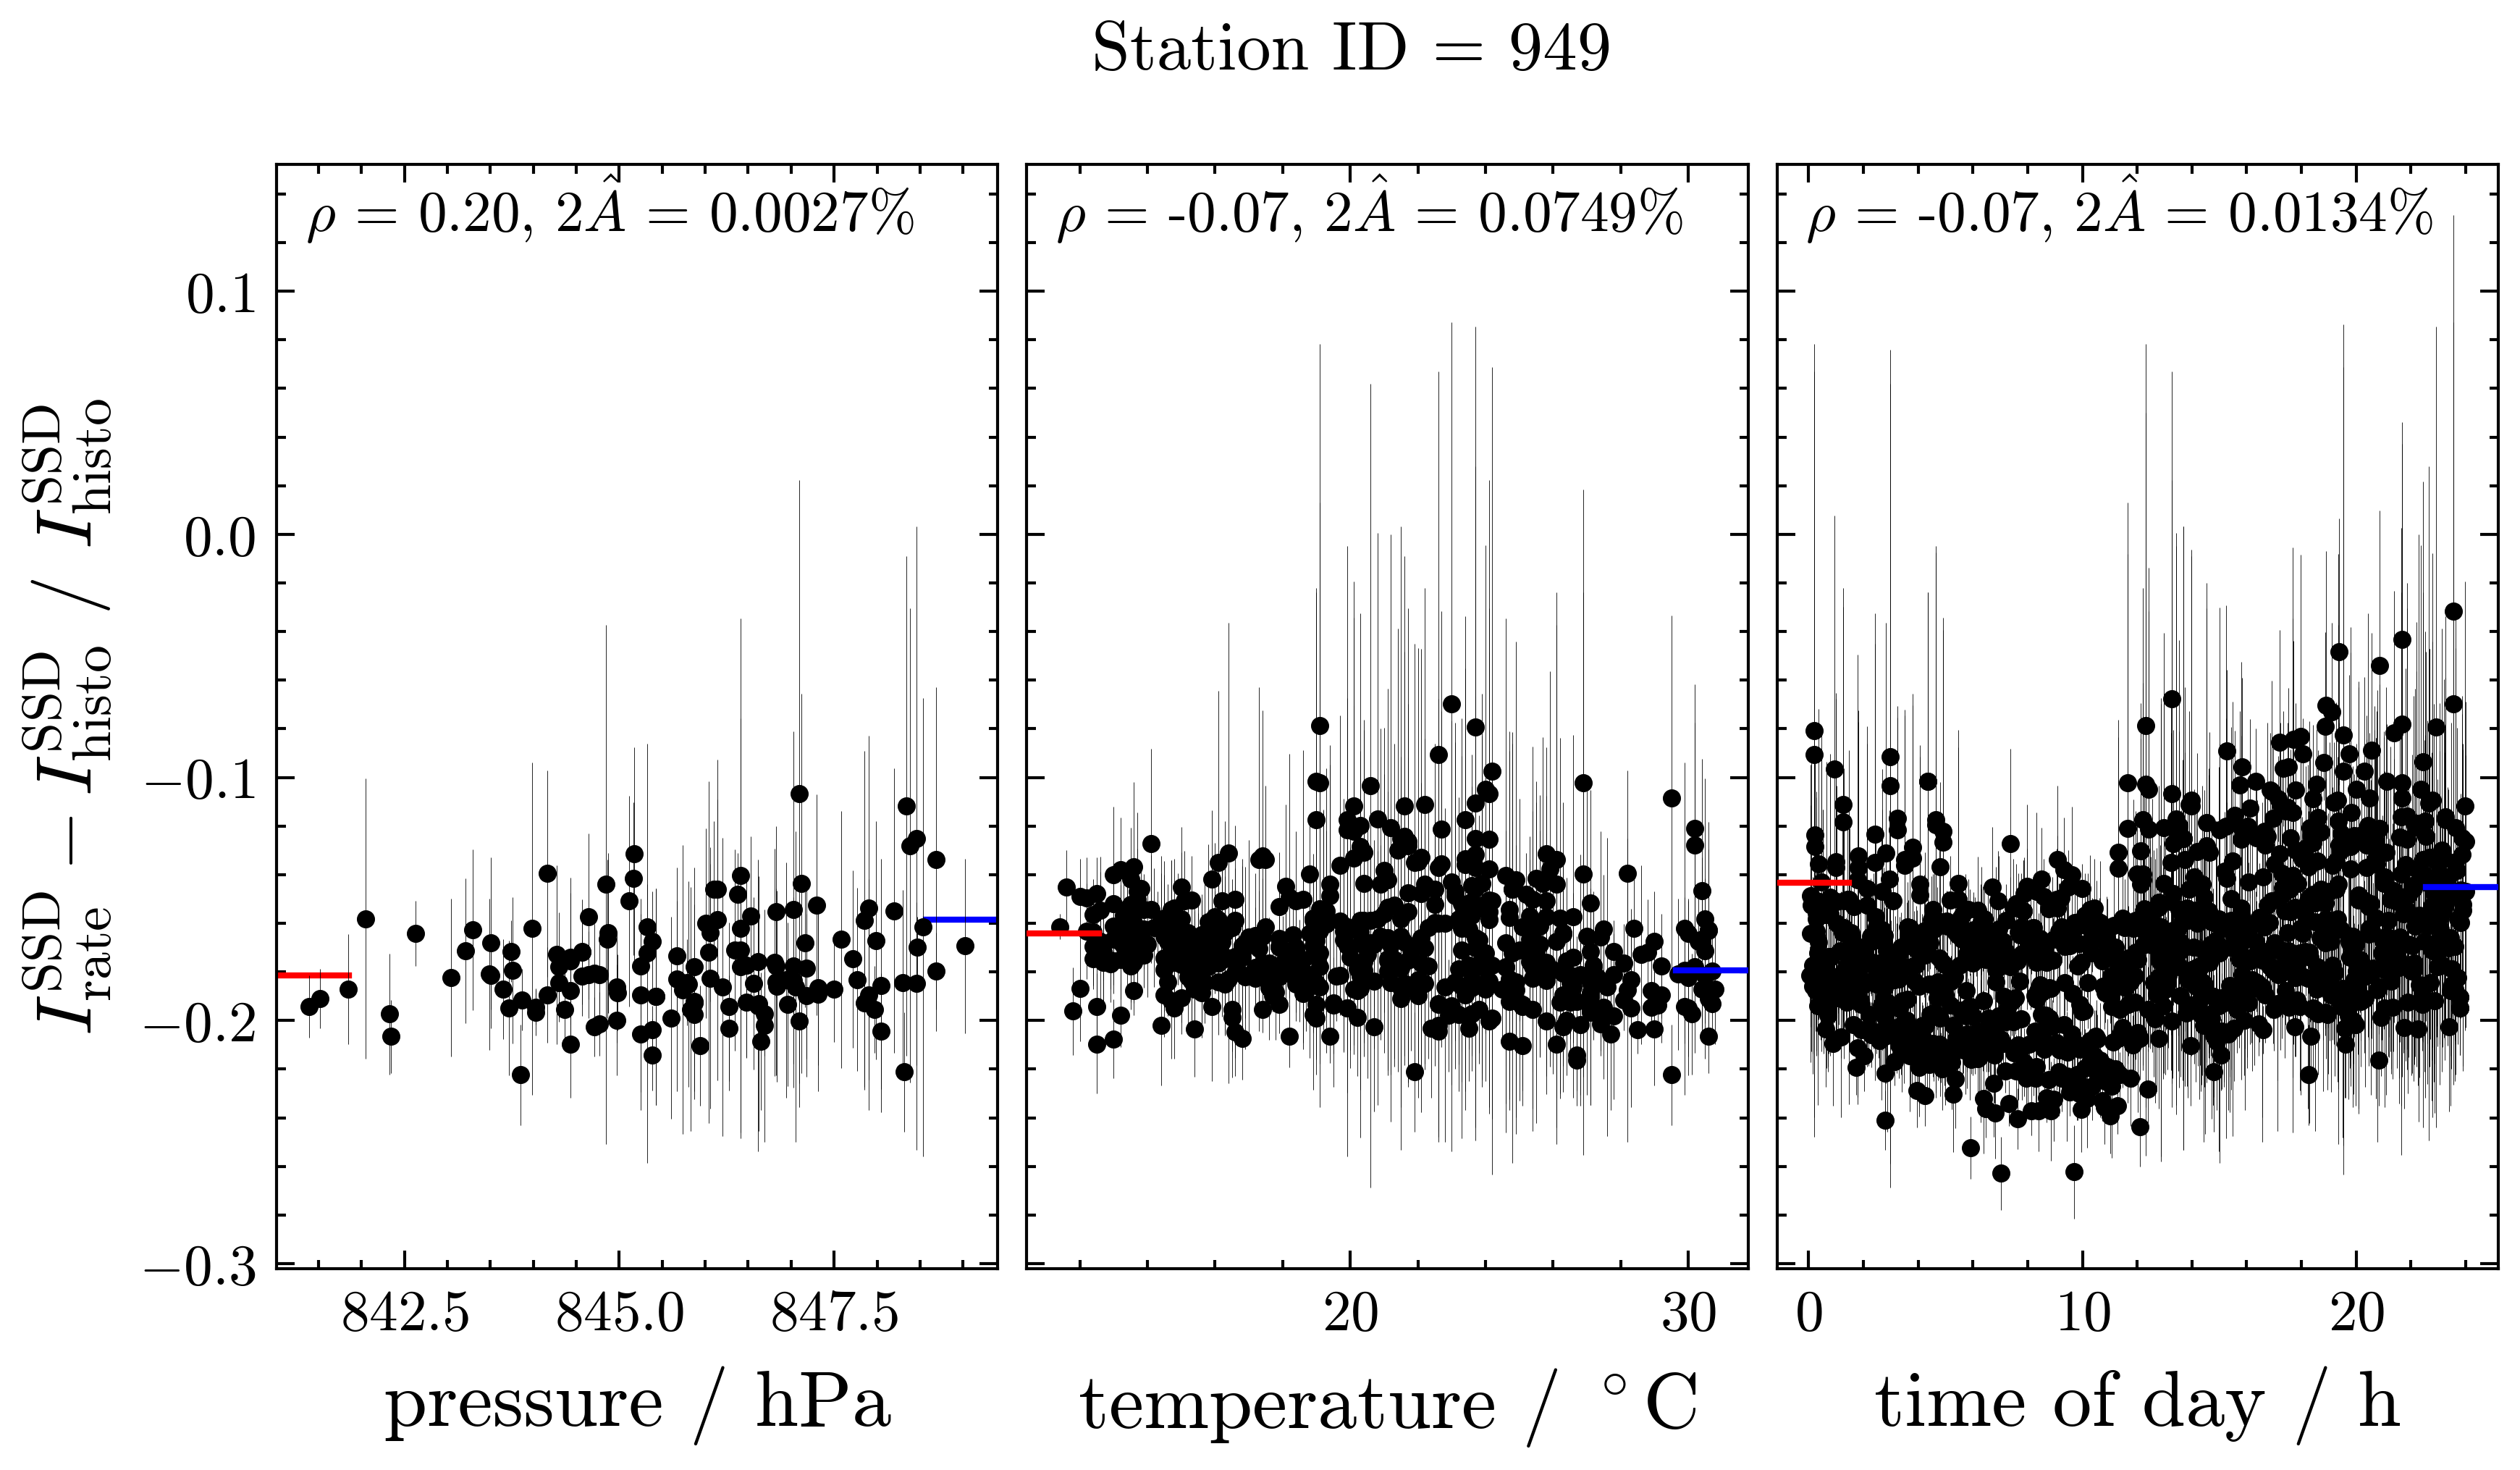

In [7]:
make_plot(949, START, STOP)

2025-01-07: temperature_measurements = 19, pressure_measurements = 0
2025-01-08: temperature_measurements = 92, pressure_measurements = 19
2025-01-09: temperature_measurements = 98, pressure_measurements = 25
2025-01-10: temperature_measurements = 95, pressure_measurements = 25
2025-01-11: temperature_measurements = 93, pressure_measurements = 23
2025-01-12: temperature_measurements = 95, pressure_measurements = 23
2025-01-13: temperature_measurements = 97, pressure_measurements = 25


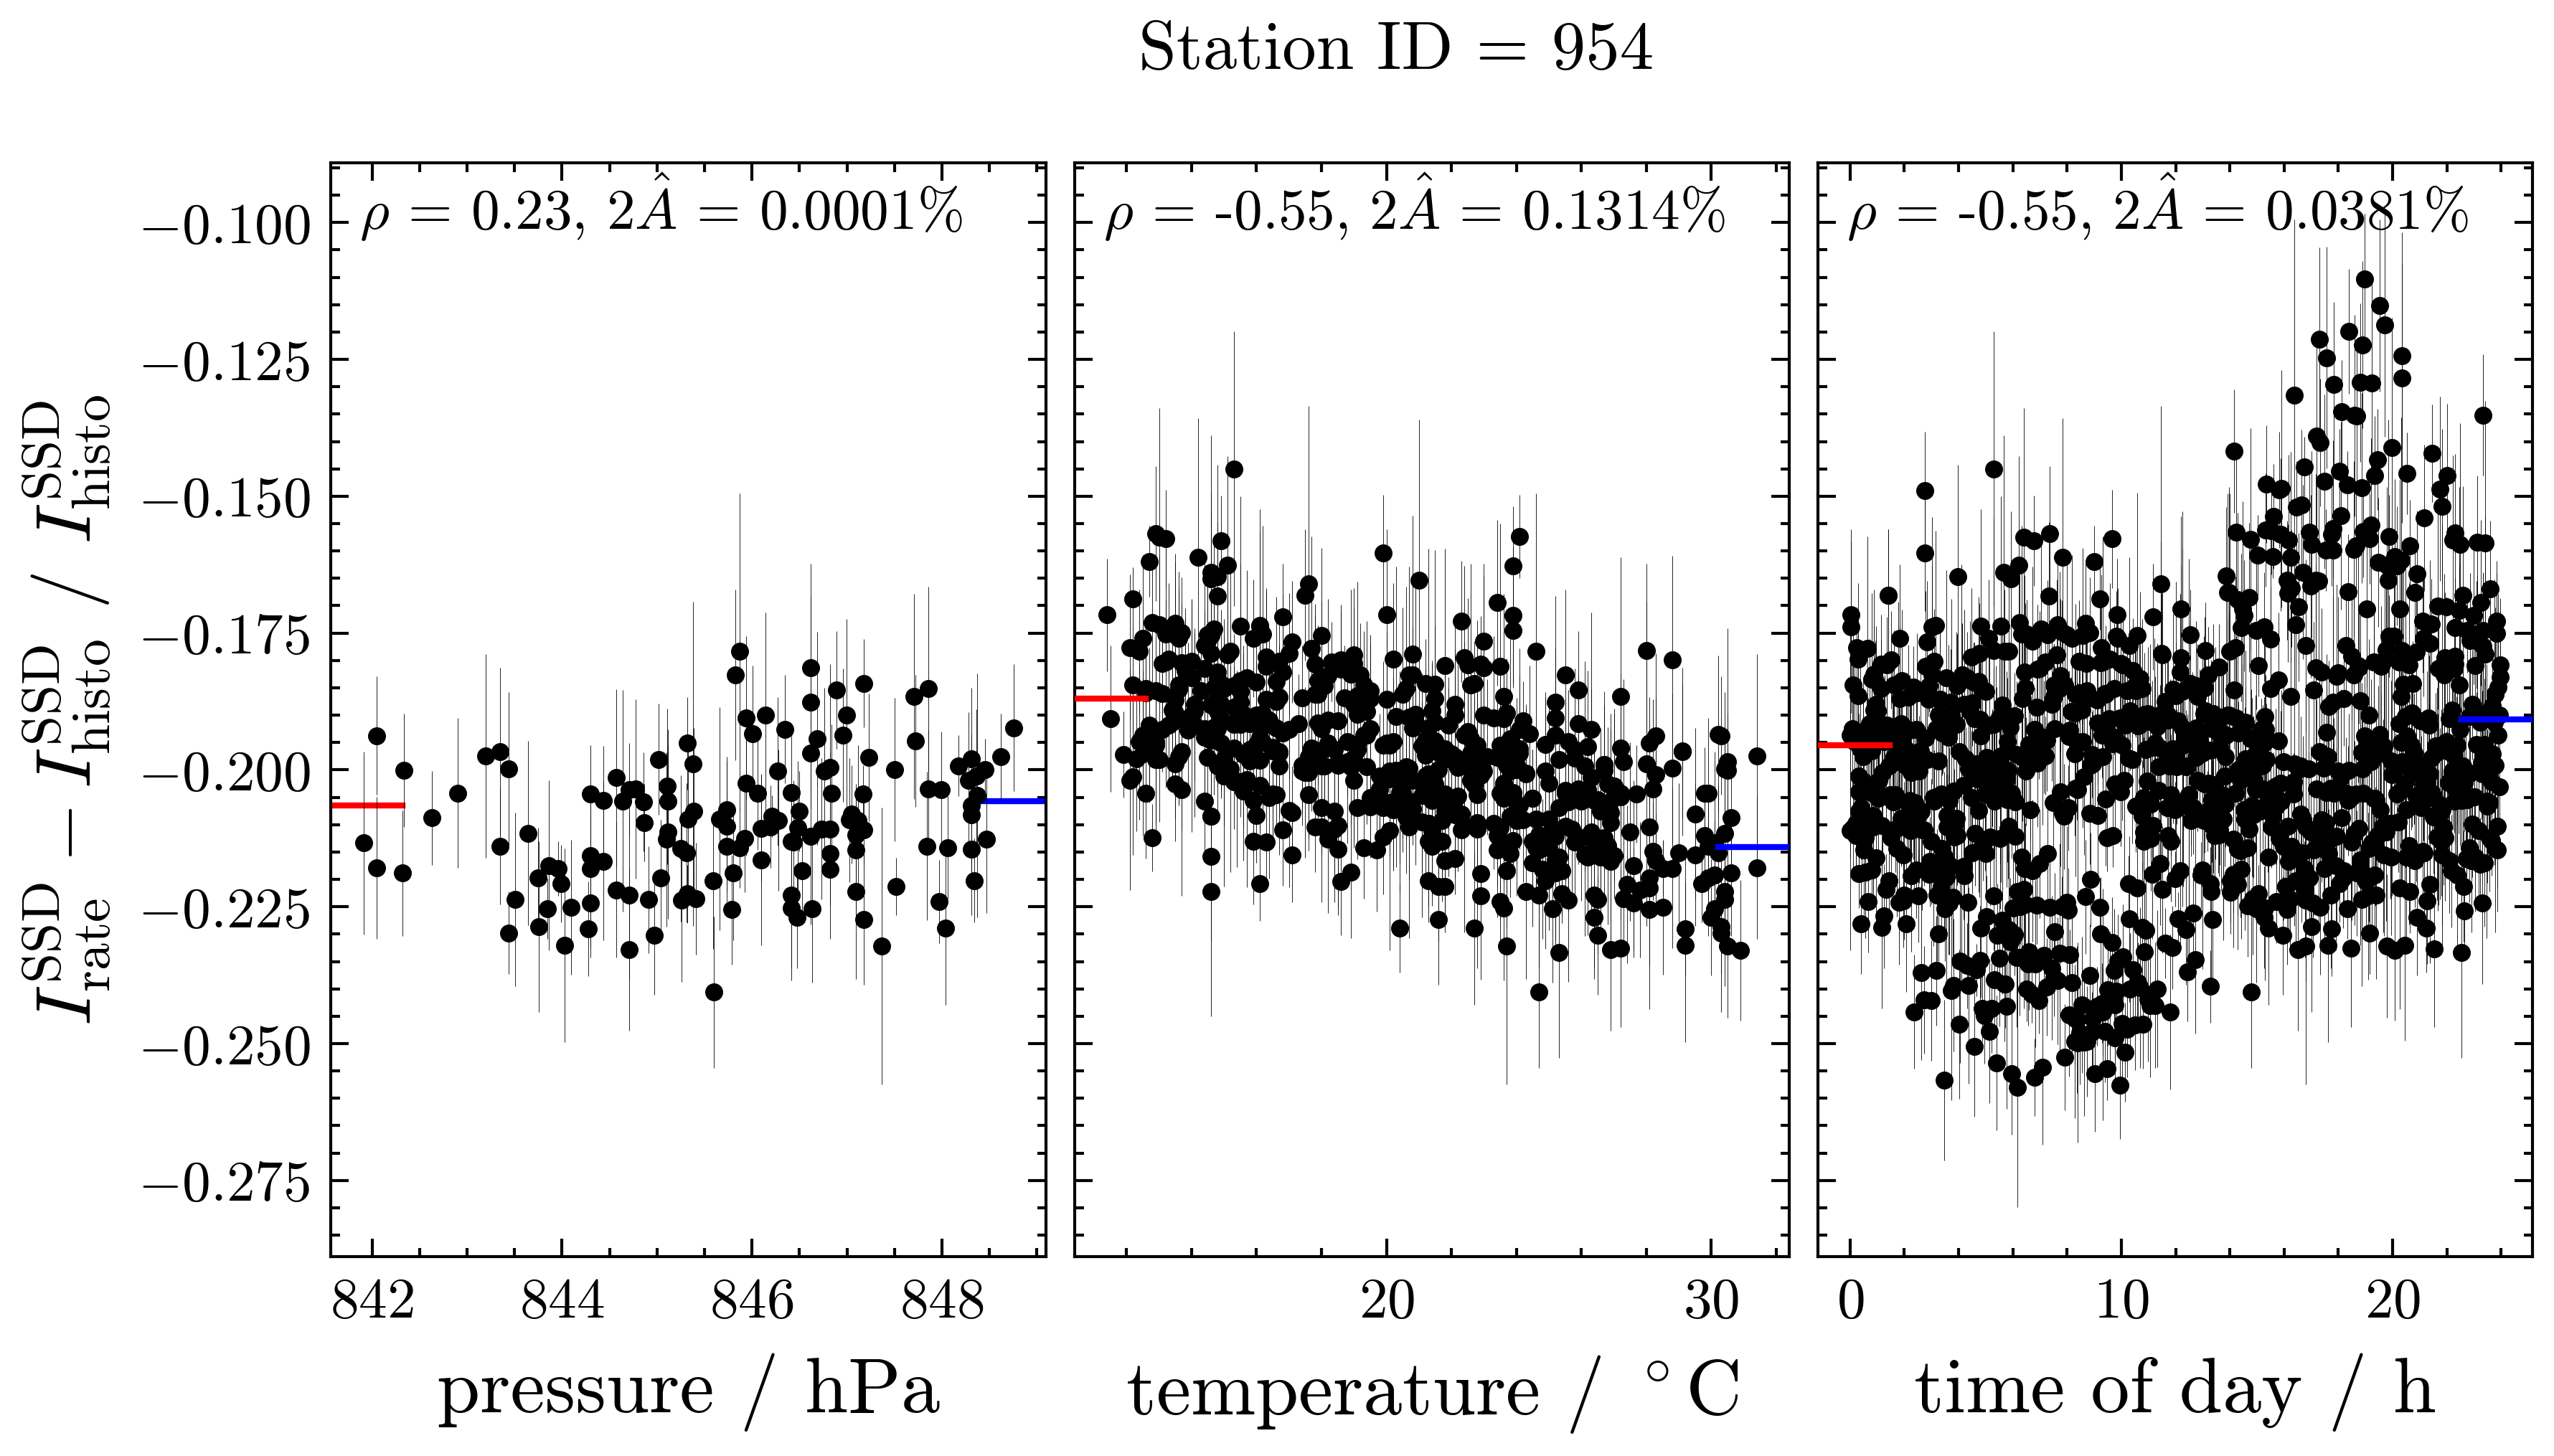

In [8]:
make_plot(954, START, STOP)